In [1]:
import numpy as np
import pandas as pd
from typing import List, Iterable
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import DecisionTree
warnings.filterwarnings('ignore')
from google.oauth2 import service_account

In [2]:
# Достаем данные из BQ
project_id = 'kolesa-android-app'
credentials = 'kolesa-android-app-c484e27f0c86.json'
credentials = service_account.Credentials.from_service_account_file(credentials)
q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""
df = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')
df

Downloading: 100%|█████████████████████████████████████████████████████████████|


,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435
...,...,...
1091,2022-12-27,17042
1092,2022-12-28,16195
1093,2022-12-29,14966
1094,2022-12-30,13070


In [3]:
# Чтобы данные можно было прочитать без доступа, сохранила датафрейм в csv
# df.to_csv('data.csv')

In [4]:
# В случае, если нет доступа к BQ
# df = pd.read_csv('data.csv')
# df

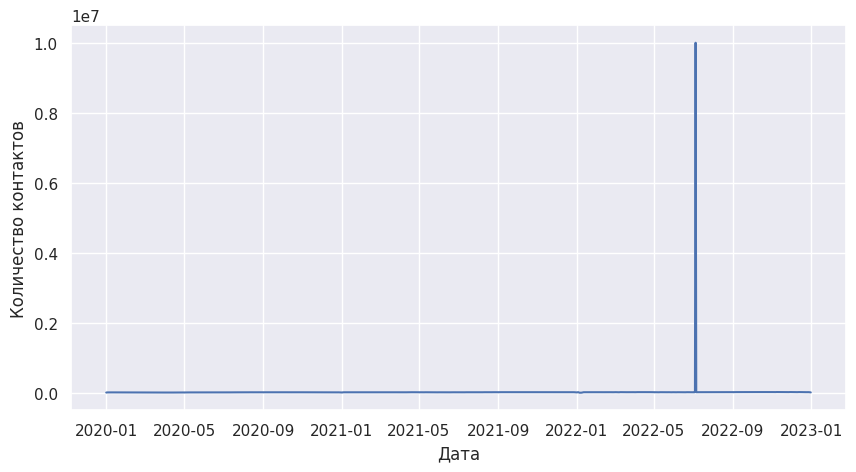

In [5]:
# Начнем с обычной визуализации всех наших данных
sns.set_theme(rc={'figure.figsize':(10,5)})
plt.xlabel('Дата')
plt.ylabel('Количество контактов')
sns.lineplot(x=df.event_date, y=df.y);

In [6]:
# И базовых статистик количества контактов
df.describe()

,y
count,1096.0
mean,22644.69708
std,301666.45291
min,51.0
25%,11824.0
50%,13238.0
75%,15787.25
max,10000000.0


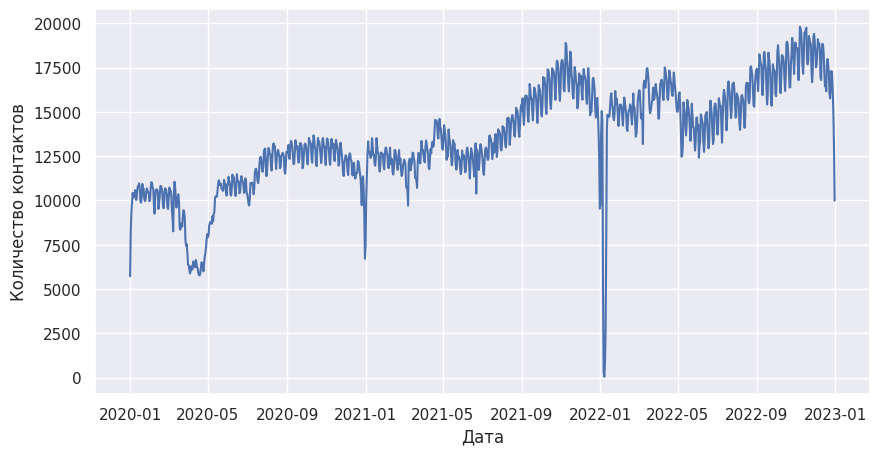

In [7]:
# Видим экстремально высокое значение (10000000), надо от него избавиться. Заменим его на среднее соседей и снова взглянем на данные
index = df['y'].argmax()
df['y'].iloc[index] = np.mean([df['y'].iloc[index-1], df['y'].iloc[index+1]])
sns.set_theme(rc={'figure.figsize':(10,5)})
plt.xlabel('Дата')
plt.ylabel('Количество контактов')
sns.lineplot(x=df.event_date, y=df.y);

In [8]:
# Добавим отдельными признаками год, месяц, день и день недели, чтобы можно было использовать их в линейной регрессии
df['event_date'] = df['event_date'].apply(pd.to_datetime)
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month
df['day'] = df['event_date'].dt.day
df['week_day'] = df['event_date'].dt.weekday
df

,event_date,y,year,month,day,week_day
0,2020-01-01,5721,2020,1,1,2
1,2020-01-02,8274,2020,1,2,3
2,2020-01-03,9344,2020,1,3,4
3,2020-01-04,9864,2020,1,4,5
4,2020-01-05,10435,2020,1,5,6
...,...,...,...,...,...,...
1091,2022-12-27,17042,2022,12,27,1
1092,2022-12-28,16195,2022,12,28,2
1093,2022-12-29,14966,2022,12,29,3
1094,2022-12-30,13070,2022,12,30,4


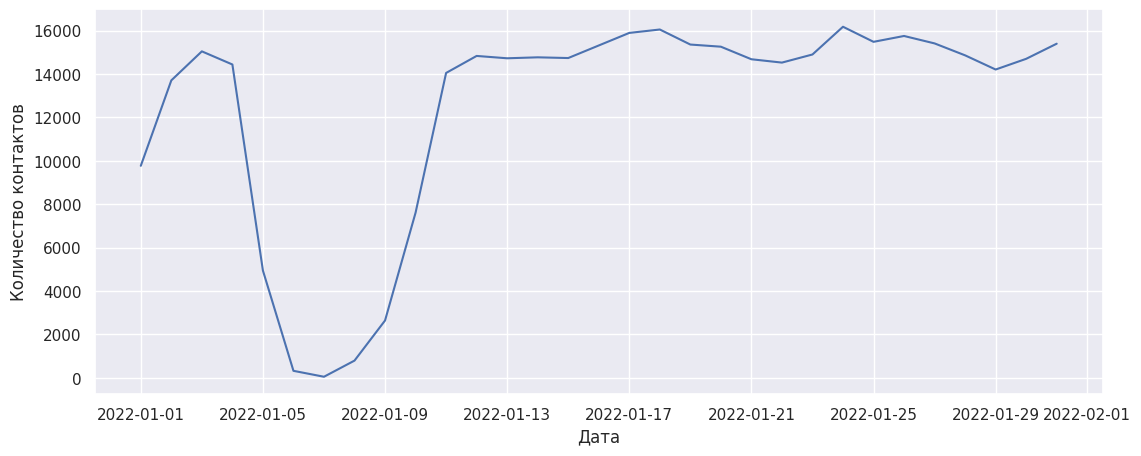

In [9]:
# На графике выше видим сильный спад в январе 2022, посмотрим на него пристальнее
jan = df[(df.year == 2022) & (df.month == 1)]
sns.set_theme(rc={'figure.figsize':(13,5)})
plt.xlabel('Дата')
plt.ylabel('Количество контактов')
sns.lineplot(x=jan.event_date, y=jan.y);

In [10]:
# Видим сильный провал в январе 2022 - Январские события. Причем просадка началась с 5 января (тогда отключили интернет) и закончилась 10-м. 
# Для того, чтобы не сбивать модель заменим эти дни средним между 4 и 11 января
df.y.loc[df.event_date == '2022-01-04'], df.y.loc[df.event_date == '2022-01-11']

(735    14441
 Name: y, dtype: Int64,
 742    14051
 Name: y, dtype: Int64)

In [11]:
# Поскольку мы будем обучаться на этих данных, лучше их заменить на среднее значения, чтобы не сбивать нашу модель
for i in range(735, 743):
    df['y'].iloc[i] = (14441 + 14051) / 2

In [12]:
# Добавим праздники как отдельный признак
holidays_kz = set(holidays.KZ(years=(2020, 2021, 2022, 2023)).keys())
def is_holiday(date):
    if datetime.date(date) in holidays_kz:
        return 1
    return 0
    
df['is_holiday'] = df['event_date'].apply(is_holiday)
df

,event_date,y,year,month,day,week_day,is_holiday
0,2020-01-01,5721,2020,1,1,2,1
1,2020-01-02,8274,2020,1,2,3,1
2,2020-01-03,9344,2020,1,3,4,0
3,2020-01-04,9864,2020,1,4,5,0
4,2020-01-05,10435,2020,1,5,6,0
...,...,...,...,...,...,...,...
1091,2022-12-27,17042,2022,12,27,1,0
1092,2022-12-28,16195,2022,12,28,2,0
1093,2022-12-29,14966,2022,12,29,3,0
1094,2022-12-30,13070,2022,12,30,4,0


In [13]:
# Добавим праздники как отдельный признак
holidays_kz = set(holidays.KZ(years=(2020, 2021, 2022, 2023)).keys())
def is_holiday(date):
    if datetime.date(date) in holidays_kz:
        return 1
    return 0
    
df['is_holiday'] = df['event_date'].apply(is_holiday)
df

,event_date,y,year,month,day,week_day,is_holiday
0,2020-01-01,5721,2020,1,1,2,1
1,2020-01-02,8274,2020,1,2,3,1
2,2020-01-03,9344,2020,1,3,4,0
3,2020-01-04,9864,2020,1,4,5,0
4,2020-01-05,10435,2020,1,5,6,0
...,...,...,...,...,...,...,...
1091,2022-12-27,17042,2022,12,27,1,0
1092,2022-12-28,16195,2022,12,28,2,0
1093,2022-12-29,14966,2022,12,29,3,0
1094,2022-12-30,13070,2022,12,30,4,0


In [14]:
# Погуглила даты ЧП с ограничением выхода в Казахстане: с 15 марта по 11 мая, отметим эти данные
def is_covid(date):
    if date > pd.to_datetime('2020-03-15') and date < pd.to_datetime('2020-05-11'):
        return 1
    return 0

# Также добавила признак "Новый год", потому что из всех праздников он самый особенный и у нас там сильнее, 
# чем в другие праздники проседает показатель
def is_NewYear(date):
    if (date.month == 1 and date.day == 1) or (date.month == 12 and date.day == 31):
        return 1
    return 0


df['is_covid'] = df['event_date'].apply(is_covid)
df['is_NewYear'] = df['event_date'].apply(is_NewYear)
df

,event_date,y,year,month,day,week_day,is_holiday,is_covid,is_NewYear
0,2020-01-01,5721,2020,1,1,2,1,0,1
1,2020-01-02,8274,2020,1,2,3,1,0,0
2,2020-01-03,9344,2020,1,3,4,0,0,0
3,2020-01-04,9864,2020,1,4,5,0,0,0
4,2020-01-05,10435,2020,1,5,6,0,0,0
...,...,...,...,...,...,...,...,...,...
1091,2022-12-27,17042,2022,12,27,1,0,0,0
1092,2022-12-28,16195,2022,12,28,2,0,0,0
1093,2022-12-29,14966,2022,12,29,3,0,0,0
1094,2022-12-30,13070,2022,12,30,4,0,0,0


In [15]:
X = df[['year', 'month', 'day', 'week_day', 'is_covid', 'is_holiday', 'is_NewYear']]
# Сделаем признаки категориальными
X = pd.get_dummies(X, columns=['month', 'day', 'week_day'], drop_first=True)
X

,year,is_covid,is_holiday,is_NewYear,month_2,month_3,month_4,month_5,month_6,month_7,...,day_28,day_29,day_30,day_31,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
0,2020,0,1,1,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,2020,0,1,0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,2020,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2020,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,2020,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2022,0,0,0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1092,2022,0,0,0,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1093,2022,0,0,0,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
1094,2022,0,0,0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False


In [16]:
# Будем обучаться сначала на 2020 и 2021, потом будем валидироваться на 2022. Подберем параметры, после чего обучимся на всех данных и предскажем 2023
X_train = np.array(X[:365*2+2])
X_val = np.array(X[365*2+2:])
y_train = np.array(df.y[:365*2+2])
y_val = np.array(df.y[365*2+2:])

In [17]:
# Подготовим тестовые данные, добавив все необходимые фичи
X_test = pd.DataFrame(pd.date_range('2023-01-01', '2023-12-31'))
X_test['year'] = X_test[0].dt.year
X_test['month'] = X_test[0].dt.month
X_test['day'] = X_test[0].dt.day
X_test['week_day'] = X_test[0].dt.weekday
X_test['is_holiday'] = X_test[0].apply(is_holiday)
X_test['is_covid'] = X_test[0].apply(is_covid)
X_test['is_NewYear'] = X_test[0].apply(is_NewYear)
X_test = X_test[['year', 'month', 'day', 'week_day', 'is_covid', 'is_holiday', 'is_NewYear']]
X_test = pd.get_dummies(X_test, columns=['month', 'day', 'week_day'], drop_first=True)
X_test

,year,is_covid,is_holiday,is_NewYear,month_2,month_3,month_4,month_5,month_6,month_7,...,day_28,day_29,day_30,day_31,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
0,2023,0,1,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2023,0,1,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2023,0,1,0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,2023,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,2023,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
361,2023,0,0,0,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
362,2023,0,0,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
363,2023,0,0,0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [18]:
X_test = np.array(X_test)

In [19]:
feature_types = ['real']+['categorical']*50

In [20]:
from DecisionTree import DecisionTreeModel
#  max_depth, min_samples_split, min_samples_leaf, 

In [21]:
decision_tree = DecisionTreeModel(feature_types=feature_types, task='regression')

In [22]:
decision_tree.fit(X_train, y_train)

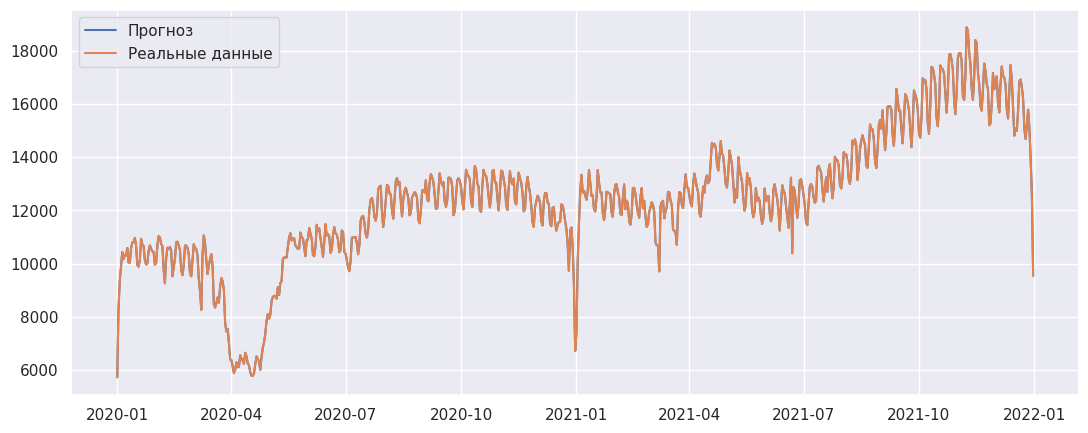

In [23]:
# дерево переобучилось под трейн
plt.plot(df['event_date'][:365*2+2], decision_tree.predict(X_train), label='Прогноз')
plt.plot(df['event_date'][:365*2+2], y_train, label='Реальные данные')
plt.legend();

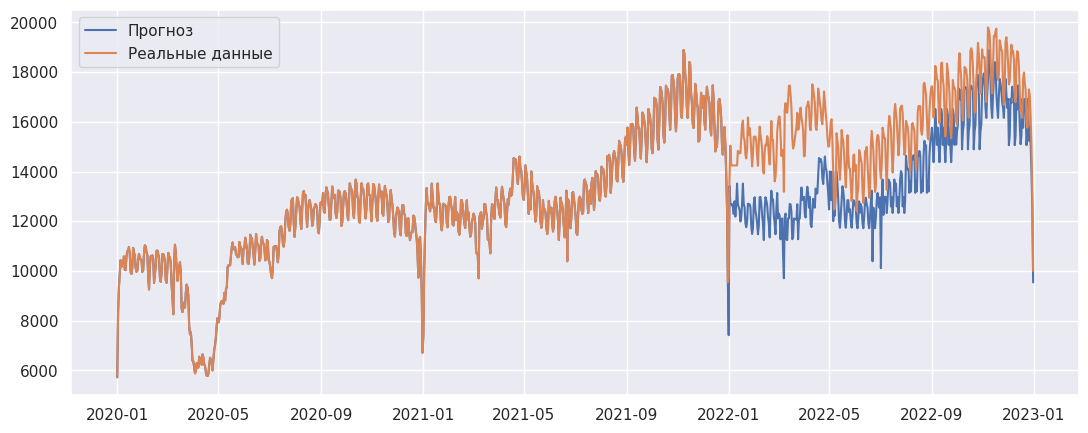

In [24]:
# Смотрим прогноз на весь временной ряд, если мы учились на 2020 и 2021
X = np.array(X)
plt.plot(df['event_date'], decision_tree.predict(X), label='Прогноз')
plt.plot(df['event_date'], df['y'], label='Реальные данные')
plt.legend();

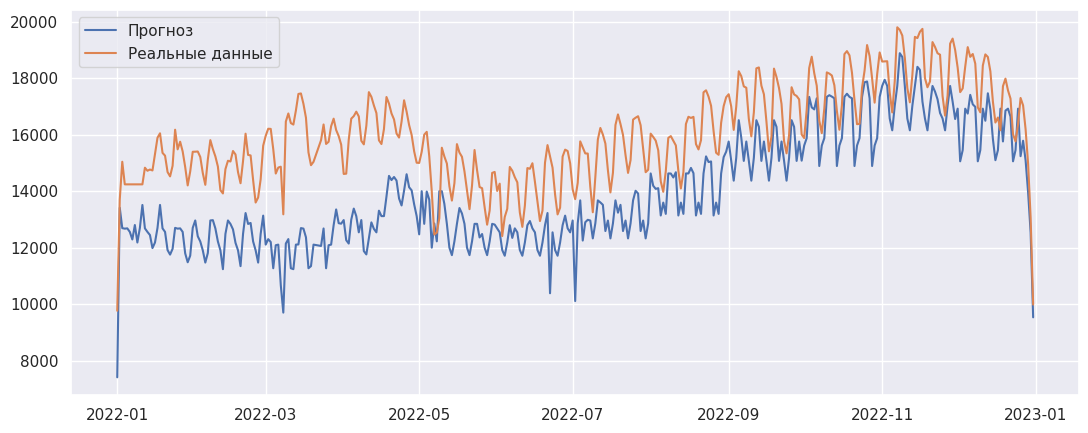

In [25]:
plt.plot(df['event_date'][365*2+2:], decision_tree.predict(X_val), label='Прогноз')
plt.plot(df['event_date'][365*2+2:], y_val, label='Реальные данные')
plt.legend();

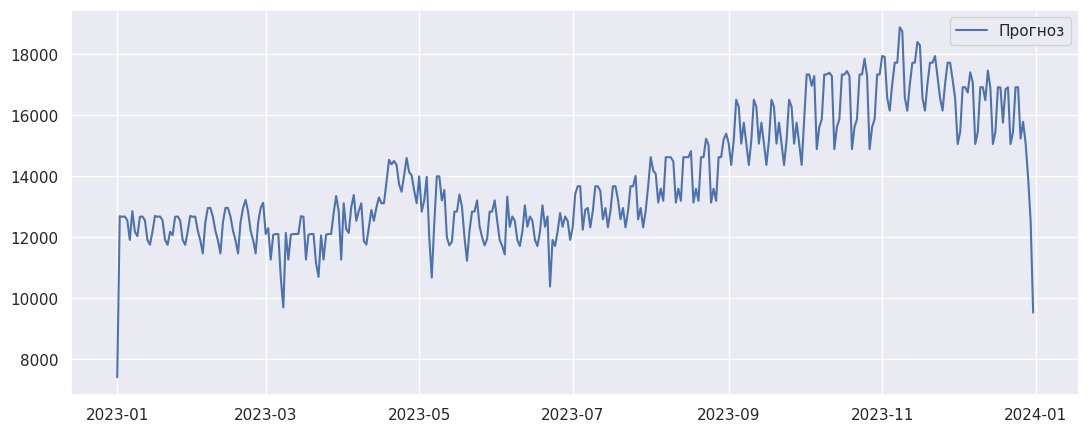

In [26]:
plt.plot(pd.date_range('2023-01-01', '2023-12-31'), decision_tree.predict(X_test), label='Прогноз')
plt.legend();

In [27]:
# И получим итоговые данные для 2023
d = {'ds': pd.date_range('2023-01-01', '2023-12-31'), 'yhat_decision_tree': decision_tree.predict(X_test)}
res = pd.DataFrame(data=d)
res.to_csv('yhat_decision_tree.csv')
res

,ds,yhat_decision_tree
0,2023-01-01,7416
1,2023-01-02,12696
2,2023-01-03,12678
3,2023-01-04,12688
4,2023-01-05,12563
...,...,...
360,2023-12-27,15789
361,2023-12-28,15097
362,2023-12-29,13955
363,2023-12-30,12539
